In [1]:
# import necessary modules
import sys
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_regression, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:06<00:00, 3856512.57it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 86601.82it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1177399.49it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5007485.39it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



# (a)

In [4]:
class NeuralNet(nn.Module):
    def __init__(self , input_size , hidden_1 , hidden_2):
        super(NeuralNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size*input_size, hidden_1),
            nn.ReLU(),
            nn.Linear(hidden_1, hidden_2),
            nn.ReLU(),
            nn.Linear(hidden_2, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.layers(x)

model = NeuralNet(28 , 128 , 64)

# (d)

In [15]:
# plot
def print_history(training_losses , accuracies , epochs) :
    # Creating figure
    fig, ax1 = plt.subplots()

    # Plotting training loss
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(np.arange(1, epochs + 1), training_losses, 'o-', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Creating a second y-axis for accuracy
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(np.arange(1, epochs + 1), accuracies, 's-', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Final adjustments
    plt.title('Training Loss and Accuracy on MNIST Dataset')
    plt.show()

# (c)

In [16]:
# test accuracy
def test(model) :
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Evaluate the trained model using the test data without gradient updates.

    print(f'Accuracy of the network on the test images: {100 * correct / total}%')
    # Print out the accuracy of the model on the test set.

# (b)

In [17]:
# train
# 紀錄最好表現之model與accuracy(accuracy來判斷是否為最好)
best_model = model
best_accuracy = 0
def trainer(model,criterion,optimizer,epochs=1,verbose=True):
    # 紀錄training時的loss與accuracy
    training_losses = [] 
    accuracies = [] 
    for epoch in range(epochs): 
        running_loss = 0
        for images, labels in trainloader :
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output , labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_training_loss = running_loss / len(trainloader)
        training_losses.append(avg_training_loss)

        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        accuracies.append(accuracy)

        print(f"Epoch {epoch+1}: Training Loss: {avg_training_loss:.4f}, Accuracy: {accuracy:.2f}%")
        global best_accuracy
        global best_model
        # 更新最好 model
        if(accuracy > best_accuracy) :
            best_accuracy = accuracy
            best_model = model

    print_history(training_losses , accuracies , epochs)
    test(best_model)

Epoch 1: Training Loss: 0.2012, Accuracy: 87.53%
Epoch 2: Training Loss: 0.1966, Accuracy: 87.99%
Epoch 3: Training Loss: 0.1916, Accuracy: 88.15%
Epoch 4: Training Loss: 0.1920, Accuracy: 87.93%
Epoch 5: Training Loss: 0.1856, Accuracy: 88.11%
Epoch 6: Training Loss: 0.1861, Accuracy: 87.66%
Epoch 7: Training Loss: 0.1839, Accuracy: 88.13%
Epoch 8: Training Loss: 0.1812, Accuracy: 86.59%
Epoch 9: Training Loss: 0.1780, Accuracy: 88.08%
Epoch 10: Training Loss: 0.1724, Accuracy: 88.49%


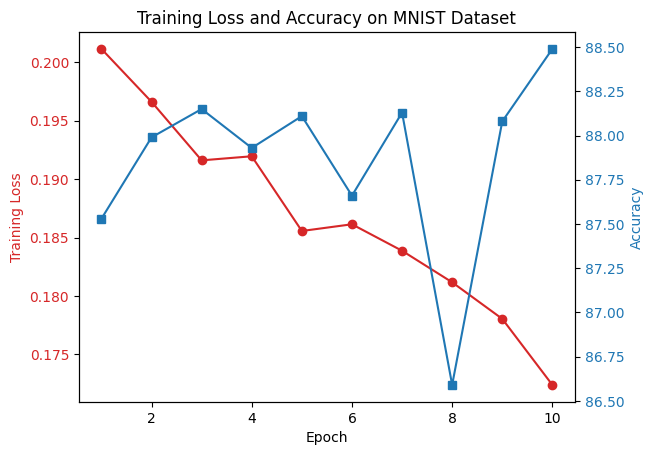

Accuracy of the network on the test images: 88.49%


In [18]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 10
trainer(model,criterion,optimizer,epochs=epochs,verbose=True) 

# (e)

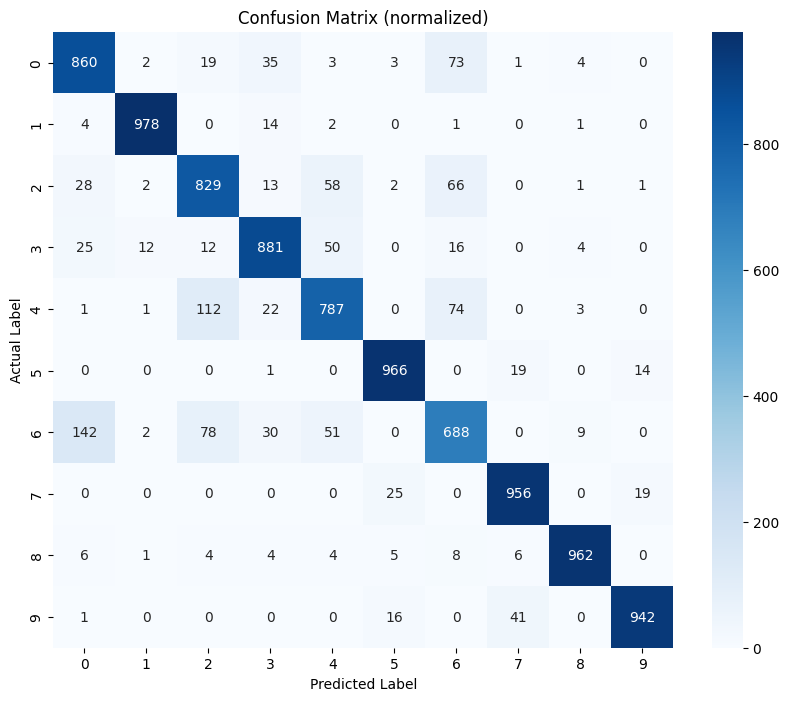

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For visualizing the confusion matrix

# Initial setup
all_predictions = []
all_labels = []

# Model evaluation
best_model.eval()
with torch.no_grad():
    for images, labels in testloader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="", cmap='Blues', xticklabels=[0,1,2,3,4,5,6,7,8,9], yticklabels=[0,1,2,3,4,5,6,7,8,9])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (normalized)')
plt.show()

# (f)

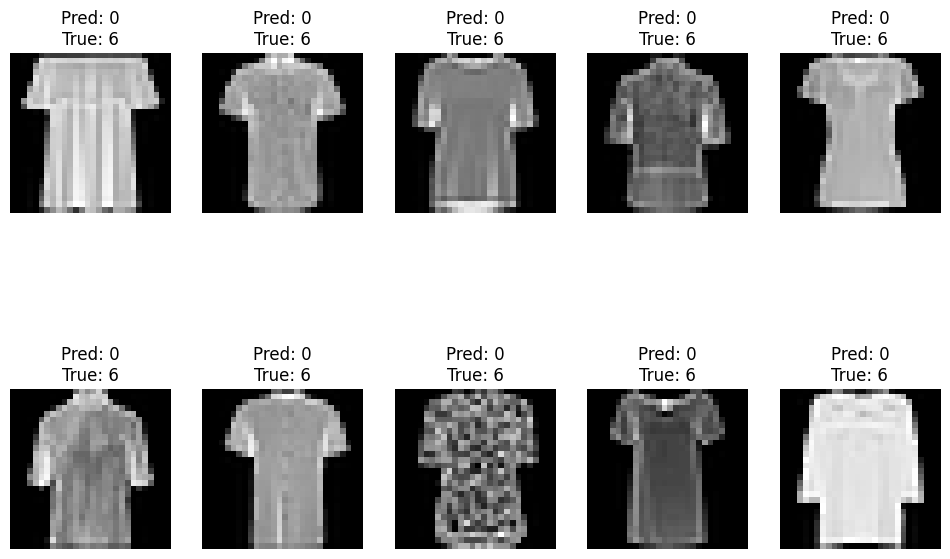

In [43]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(img.numpy().squeeze(), cmap='gray')
    
def visualize_predictions(dataloader, model, num_images=5):
    # 儲存預測 0 但 label 為 6 的圖片
    images_list = []
    # 找出預測 0 但 label 為 6 的圖片
    for images, labels in dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for idx in range(len(predicted)) :
            if(labels[idx] == 6 and predicted[idx] == 0) :
                images_list.append(images[idx])

    plt.figure(figsize=(12, 8))
    for idx in range(num_images) :
        ax = plt.subplot(2, num_images//2, idx+1)
        # 讀出該圖片
        imshow(images_list[idx])
        ax.set_title(f'Pred: 0\nTrue: 6')
        ax.axis('off')
    plt.show()

# Call the function
visualize_predictions(testloader, best_model, num_images=10)